# Getting familiar with the electrophysiology (Ephys) pipeline

In this notebook, we will take a tour of the Moser group electrophysiolgoy (ephys) pipeline, taking a close look at how each table is defined and relate to each other to represent various experimental information.

But before we begin, let's import a couple essential packages, in particular importing DataJoint (`datajoint`) package, and establish connection to the Moser lab database where the entire pipeline resides.

In [1]:
import datajoint as dj

In [2]:
dj.config['display.limit'] = 10

If you have followed all the setups for Python environment, DataJoint and the Ephys pipeline as described in [Zero to DataJoint Wiki page](https://github.com/kavli-ntnu/dj-elphys/wiki/Zero-to-datajoint), you should be able to just run the next line, importing pipeline definitions as found in the `ephys` package.

In [6]:
from ephys import reference, acquisition, tracking, behavior, ephys, analysis
animal = dj.create_virtual_module('mlims', dj.config['custom'].get('mlims.database', 'prod_mlims_data'))

Connecting thinh@datajoint.it.ntnu.no:3306


If you experienced any issue in importing the pipeline, please refer to the [Wiki page and guide](https://github.com/kavli-ntnu/dj-elphys/wiki/Zero-to-datajoint) again or seek help from administrators.

The entire pipeline is quite elaborate and contains many parts, grouping related tables together to facilitate navigation and understanding. Rather than looking at them all at once, we will now take a look at each of these groups of tables or **schemas**, one at a time.

## Animal information

Just like any experiment cannot occur without the animal, the entire pipeline also beging with capturing information about the animal. Naturally, information pertaining to the animal can be found under the `animal` schema.

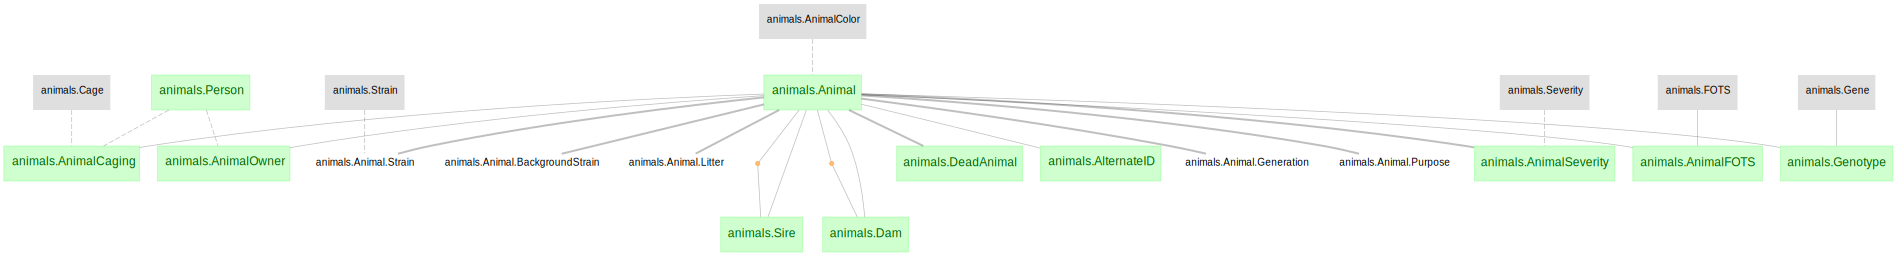

In [15]:
dj.Diagram(animal)

Among other things, the `animal.Animal` table contains listing of all animals in the lab, and as we will see, serve as the starting point for the entire ephys pipeline.

In [17]:
animals.Animal()

animal_id,datasource_id,animal_species,animal_name,animal_sex,animal_dob,color
0000da5d6810d149,0,mouse,85106,F,2018-10-07,None
0000df481fc1421d,0,rat,20399,F,2014-08-06,None
00016d089675e2f2,0,mouse,55885,M,2016-02-12,None
0003a07550faa59b,0,mouse,78224,F,2017-11-30,None
0005070177484ee2,0,rat,20259,M,2014-07-21,None
0005baadae264d7b,0,rat,24790,F,2018-04-12,None
00062843f7d3ffce,0,mouse,55391,F,None,None
00062e8c65bb14f3,0,mouse,52756,M,2015-02-27,None
0006d0993fd101e8,0,mouse,78886,F,2017-12-25,None
00080a60ab6366cd,0,mouse,83976,F,2018-08-01,None


Each animal is uniquely captured by a combination of `animal_id` and `datasource_id`. `datasource_id=0` indicates that these are animals found in MLIMS colony management system.

### Querying tables

In DataJoint, you can probe into or **query** tables to get a specific subset of data that you may be interested in. The most common type of query is **restriction**, where you'll subselect entries based on specific criteria.

#### Question: Find only rats

In [11]:
mlims.Animal & 'animal_species = "rat"'

animal_id,datasource_id,animal_species,animal_name,animal_sex,animal_dob,color
0000df481fc1421d,0,rat,20399,F,2014-08-06,None
0005070177484ee2,0,rat,20259,M,2014-07-21,None
0005baadae264d7b,0,rat,24790,F,2018-04-12,None
00157eb065da5a2e,0,rat,20461,F,2014-08-27,None
0019025c22abd502,0,rat,20858,F,2014-12-30,None
002bd5b22e5d7d6c,0,rat,21039,F,2015-02-25,None
00342c6d86e97d43,0,rat,25558,F,2019-03-09,None
0057b5e746099ace,0,rat,22414,F,2016-03-04,None
00592804fdd6aec0,0,rat,25624,M,2019-03-26,None
00686ec8eaccdf15,0,rat,20135,M,2014-05-08,None


#### Question: Find only animals born after 2017

In [23]:
animal.Animal & 'animal_dob >= "2017-01-01"'

animal_id,datasource_id,animal_species,animal_name,animal_sex,animal_dob,color
0000da5d6810d149,0,mouse,85106,F,2018-10-07,None
0003a07550faa59b,0,mouse,78224,F,2017-11-30,None
0005baadae264d7b,0,rat,24790,F,2018-04-12,None
0006d0993fd101e8,0,mouse,78886,F,2017-12-25,None
00080a60ab6366cd,0,mouse,83976,F,2018-08-01,None
000ea1b041445113,0,mouse,79495,F,2018-01-16,None
001345c95b628f23,0,mouse,78920,F,2017-12-27,None
002882f36ab6eb61,0,mouse,75370,F,2017-07-09,None
002c4e24b7cdc33a,0,mouse,76509,M,2017-09-25,None
00342c6d86e97d43,0,rat,25558,F,2019-03-09,None


### Getting data out of the table

Once you form your desired query result, you can **fetch** back the data from the tables by calling `fetch` on the query result.

In [97]:
# get all information about animals born on or after 2017
data = (animal.Animal & 'animal_dob >= "2017-01-01"').fetch()

In [99]:
data.shape

(22467,)

### Getting list of unique animals

You can just get the identifying information of the table by grabbing (or **fetching**) the `KEY` of the table, and then using this to **restrict** the entries.

In [100]:
keys = (animal.Animal & 'animal_dob >= "2017-01-01"').fetch('KEY')

In [103]:
keys[:5]  # first five keys

[{'animal_id': '0000da5d6810d149', 'datasource_id': 0},
 {'animal_id': '0003a07550faa59b', 'datasource_id': 0},
 {'animal_id': '0005baadae264d7b', 'datasource_id': 0},
 {'animal_id': '0006d0993fd101e8', 'datasource_id': 0},
 {'animal_id': '00080a60ab6366cd', 'datasource_id': 0}]

Get specific animal back

In [105]:
# get the first animal back
animal.Animal & keys[0]

animal_id,datasource_id,animal_species,animal_name,animal_sex,animal_dob,color
0000da5d6810d149,0,mouse,85106,F,2018-10-07,None


## Electrophysiology Session

In order to understand how the entire `ephys` pipeline is organized, it is essential to first understand what we mean by "a session".

The following figure illustrates the structure of an electrophysiology experiment session.

<img src="../images/Ephys_Session_Structure.png" alt="drawing" width="700"/>

A single experimental **session** consists of one or more of the following:
* tracking data stream (recording from animal tracker) -- referred to as **tracking** data
* electrophsyiology data stream (recording from a single probe) -- referred to as **recording** data

Within a single **session**, you can get any number of the above, with possibility of having multiple probe recordings occuring simultaneously (e.g. when recording from two or more probes at the same time).

While the experimenter is free to split any number of recordings/trackings into a desired number of sessions, an **experimental session** is typically considered to be a single coherent collection of recordings, and is also typically the basic unit for the downstream analysis.

Additionally, a single **session** may be assocciated with one or more **tasks**, usually labeling the particular behavioral task or environment that the animal is exposed to.

To represent the above complexity, we make use of multiple related tables, starting with `Session`, representing a single experimental session in the pipeline. 

An experimental `Session` can be uniquely identified by knowing the **animal** and **the exact date time** of the experiment session. This is reflected in the definition of the `Session` table.

In [26]:
acquisition.Session()

animal_id,datasource_id,session_time start time of this session,session_note
00342c6d86e97d43,0,2019-07-04 20:35:12,=BLOB=
40bfa03a7a7018cc,0,2019-09-17 19:43:06,=BLOB=
61fd2ac184c13c73,0,2017-10-02 15:54:25,=BLOB=
61fd2ac184c13c73,0,2018-01-02 11:20:23,=BLOB=
6a61369265b193e8,0,2017-09-08 14:58:22,=BLOB=
6a61369265b193e8,0,2017-10-04 11:15:32,=BLOB=
6a61369265b193e8,0,2018-01-08 13:19:31,=BLOB=
724240a0a756020f,0,2018-04-24 10:25:23,=BLOB=
96129eb1563c0b0d,0,2018-06-21 12:59:28,=BLOB=
bbd19fe400fac5a6,0,2019-09-10 15:34:57,=BLOB=


Looking at the *definition* of the table, we see that `Session` table **refers to `Animal` table** to indicate that each `Sessions` depends on an `Animal`. In other words, you cannot possibly have an experiment session without a corresponding animal.

In [28]:
acquisition.Session.describe();

-> animals.Animal
session_time         : datetime                     # start time of this session
---
session_note=null    : longblob                     



This relationship is captured by the following table **diagram**

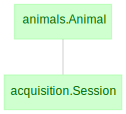

In [29]:
dj.ERD(animal.Animal) + acquisition.Session

## Recording and Tracking

As was mentioned above, we expect to find one or more electrode probe recordings and/or tracking data stream. These information are represented by `Recording` and `Tracking` tables, respectively.

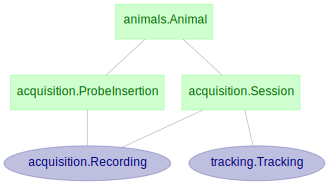

In [38]:
dj.Diagram(animal.Animal) + acquisition.Session + acquisition.Recording + tracking.Tracking + acquisition.ProbeInsertion

The extended diagram now captures the relationship between `Session` and the two new tables `Recording` and `Tracking`. However, notice that `Recording` also *depends* on another table -- `ProbeInsertion`.

## Understanding recording - working with probes

In [36]:
acquisition.Recording.describe();

-> acquisition.Session
-> acquisition.ProbeInsertion
recording_time       : datetime                     # start time of this recording
---
-> reference.RecordingSystem
-> reference.ElectrodeConfig
recording_order      : smallint                     # the ordering of this recording in this session
recording_duration   : float                        # (s) duration of this recording
recording_name=""    : varchar(40)                  # name of this recording (e.g. 27032019laserSess1)



Looking at the definition of `Recording` table, we can see that it depends on two parent tables -- `acquisition.Session` and `acquisition.ProbeInsertion`. Dependency on `acquisition.Session` ensures that each recording must be associated with exactly one `Session` entry. What is the dependency on `ProbeInsertion` about? 

If you guessed that this captures exactly which electrode probe that the recording was performed on, then you guessed right! `ProbeInsertion` table actually represents the final table in a chain of tables capturing precise information about the probe that was inserted into the animal.

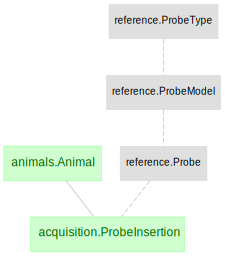

In [43]:
dj.Diagram(acquisition.ProbeInsertion) - 1 + reference.ProbeModel + reference.ProbeType

In [46]:
acquisition.ProbeInsertion.describe();

-> animals.Animal
insertion_time       : datetime                     # When this probe was inserted
---
-> reference.Probe
insertion_note=""    : varchar(1000)                # some notes



Conceptually, an entry in `ProbeInsertion` table represents a particular event of probe insertion into the animal, and this is uniquely identified by knowing on **which animal** and **when** the insertion was performed. You can also see that `ProbeInsertion` *refers* to `Probe` table, thereby indicating what `Probe` was actually inserted.

In [47]:
reference.Probe()

probe unique identifier of this probe (e.g. serial number),"probe_model nick name, or other user-friendly model name of this probe"
microdrive_86866,4-tetrode-array
tetrode_74472,4-tetrode-array
tetrode_74956,4-tetrode-array
tetrode_88068_1,4-tetrode-array
tetrode_88068_2,4-tetrode-array
microdrive_24321_1,8-tetrode-array
microdrive_24321_2,8-tetrode-array
tetrode_32c,8-tetrode-array
Neuropixel_1,neuropixels_1.0
Neuropixel_2,neuropixels_1.0


In [49]:
reference.Probe.describe();

# represent a physical probe
probe                : varchar(32)                  # unique identifier of this probe (e.g. serial number)
---
-> reference.ProbeModel



An entry in `Probe` table refers to a specific *physical instance* of a probe, with some string of characters used to uniquely identify the probe (e.g. name or serial number of the probe). Again, `Probe` *refers* to `ProbeModel` table, that now captures the **model** of the probe, such as neuropixel probe version 1.0 or 4 probe tetrode array.

In [51]:
reference.ProbeModel()

"probe_model nick name, or other user-friendly model name of this probe",probe_type
neuropixels_1.0,neuropixels
4-tetrode-array,tetrode_array
8-tetrode-array,tetrode_array


In [52]:
reference.ProbeModel.describe();

# represent a probe model
probe_model          : varchar(32)                  # nick name, or other user-friendly model name of this probe
---
-> reference.ProbeType



Finally, each `ProbeModel` *refers* to the type of probe, which is a more general grouping of probe classifiation, such as neuropixels or tetrode array.

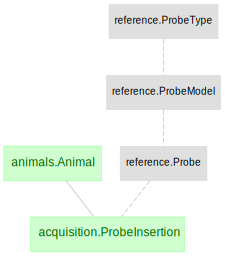

In [53]:
dj.Diagram(acquisition.ProbeInsertion) - 1 + reference.ProbeModel + reference.ProbeType

Put together, `ProbeInsertion` allows experimenters to capture the information about the probe that was inserted into an animal.

## Recordings

Now we understand what `ProbeInsertion` table captures, let's get back to `Recording` table.

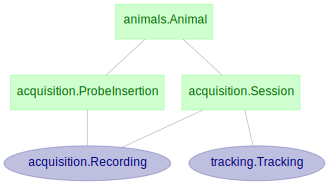

In [54]:
dj.Diagram(animal.Animal) + acquisition.Session + acquisition.Recording + tracking.Tracking + acquisition.ProbeInsertion

In [55]:
acquisition.Recording.describe();

-> acquisition.Session
-> acquisition.ProbeInsertion
recording_time       : datetime                     # start time of this recording
---
-> reference.RecordingSystem
-> reference.ElectrodeConfig
recording_order      : smallint                     # the ordering of this recording in this session
recording_duration   : float                        # (s) duration of this recording
recording_name=""    : varchar(40)                  # name of this recording (e.g. 27032019laserSess1)



Notice that a entry in `Recording` is uniquely identified by a unique combination of a `Session`, `ProbeInsertion`, **and recording time**! It is the presence of this last primary key attribute that enables more than one recording to be present for each combination of `Sessions` and `ProbeInsertion`. In other words, within a `Session`, you can have more than one recordings from the same probe, as long as they are separated in time (`recording_time`).

Now you may have noticed that `Recording` also *refers* to a number of other tables. This is graphically depicted by the following diagram.

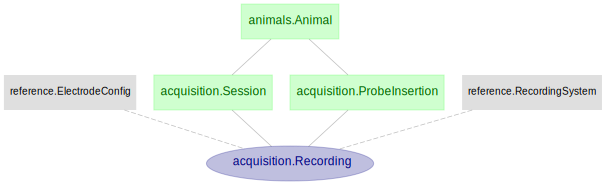

In [57]:
dj.Diagram(acquisition.Recording) + animal.Animal + acquisition.Session + acquisition.ProbeInsertion + reference.RecordingSystem + reference.ElectrodeConfig

`RecordingSystem`, as the name indicates, keeps track of different recroding systems.

In [59]:
reference.RecordingSystem()

recording_system
axona
neuralynx
neurologger
neuropixels


`ElectrodeConfig` is a bit more complex, referring to the exact configurations of groupings of channels found in a probe that the recording occured for. We will revisit this table and other related tables later in this notebook.

## Tracking data

In contrast to the `Recording` table, `Tracking` table contains information about a particular tracking data stream found inside a session.

In [72]:
tracking.Tracking().describe();

-> acquisition.Session
tracking_time        : datetime                     # start time of this tracking recording
---
-> tracking.TrackingType
tracking_name        : varchar(40)                  # user-assign name of this tracking (e.g. 27032019laserSess1)
tracking_sample_rate : float                        # (Hz)
tracking_timestamps  : longblob                     # (s) timestamps of the frame in the tracking system clock, w.r.t the start of this tracking



Again, `Tracking` *refers* to `Session` but also has it's own primary key attribute `tracking_time`, allowing for more than one tracking to be present per session, as long as they are separated in time. 

### Where is the data?

While `Recording` and `Tracking` tables both represented data recordings, you may have noticed that we didn't see the actual data points present in the table. This is because these tables are used to describe information **about recording and tracking**, and the actual data are loaded and handled by downstream tables as we will see shortly.

## Clustering

While a stream of electrical activities in itself can be interesting (i.e. refer to `LFP` below), we are often interested in working with individual spikes, and thus want to perform spike detection/clustering on the raw signal to extract these spikes. The ephys pipeline is built so that it can express very complex configurations of clustering.

Namely, **arbitrary time segments from one or more recordings across one or more sessions** can be combined to be the target of clustering. Let's now take a look at how that is represented in the tables.

### Specification of clustering time windows

To allow for flexible combination of one or more sessions, `ClusterSessionGrouping` table is used.

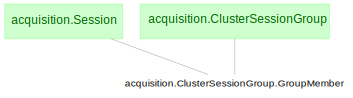

In [89]:
dj.Diagram(acquisition.ClusterSessionGroup) + acquisition.Session + acquisition.ClusterSessionGroup.GroupMember

In [92]:
acquisition.ClusterSessionGroup.describe();

group_name           : varchar(36)                  
---
group_desc=""        : varchar(128)                 



`ClusterSessionGroup` table simply defines a group of one or more sessions, and the `ClusterSessionGroup.GroupMember` ties the member sessions to the group it belongs to.

Taking a look at an example group.

In [111]:
keys = acquisition.ClusterSessionGroup().fetch('KEY')

In [113]:
acquisition.ClusterSessionGroup() & keys[0]

group_name,group_desc
det_0d7c5dd06d63c5f14395b914f7f803e7,Default session grouping for animal 724240a0a756020f on 25242018 10:25:23


and members for this session group

In [114]:
acquisition.ClusterSessionGroup.GroupMember & keys[3]

group_name,animal_id,datasource_id,session_time start time of this session
det_5f5bbc4f242344ec7acdc63012cb0396,ca13934830a1af36,0,2017-11-23 15:58:00


### Specifying time windows

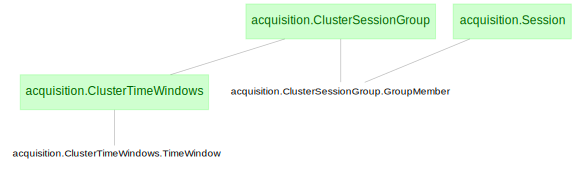

In [118]:
dj.ERD(acquisition.ClusterTimeWindows.TimeWindow()) + acquisition.ClusterTimeWindows + acquisition.ClusterSessionGroup +  acquisition.ClusterSessionGroup.GroupMember + acquisition.Session

Once a group of one or more sessions is defined, `ClusterTimeWindows` and `ClusterTimeWindows.TimeWindow` are  used to subselect one or more time windows within the **concatenated session data**.

In [124]:
acquisition.ClusterTimeWindows.TimeWindow.describe();

-> acquisition.ClusterTimeWindows
window_start         : decimal(6,2)                 # (s) onset of this window, with respect to session onset
---
window_stop          : float                        # (s) offset of this window, with respect to session onset



'-> acquisition.ClusterTimeWindows\nwindow_start         : decimal(6,2)                 # (s) onset of this window, with respect to session onset\n---\nwindow_stop          : float                        # (s) offset of this window, with respect to session onset\n'

In [40]:
acquisition.ProbeInsertion().describe();

-> animals.Animal
insertion_time       : datetime                     # When this probe was inserted
---
-> reference.Probe
insertion_note=""    : varchar(1000)                # some notes



'-> animals.Animal\ninsertion_time       : datetime                     # When this probe was inserted\n---\n-> reference.Probe\ninsertion_note=""    : varchar(1000)                # some notes\n'

In one ***Session***, there can be:
+ multiple trackings (in time)
+ multiple recordings (in time)
    + one recording per probe
+ multiple probes (different insertion sites)
+ multiple tasks

### Probe and Probe Insertion

### Following the above experiment organization, the diagram below shows the design of the session related part of the ephys pipeline

![session overview](../images/session_overview_erd.png)

An experiment ***Session*** can be uniquely identified by knowing the **animal** and **the exact date time** of the experiment session. This is reflected in the definition of the `Session` table.

In [28]:
acquisition.Session.describe();

-> mlims.Animal
session_time         : datetime                     # start time of this session
---
session_note=null    : longblob                     



Additionally, each session can contain `session_note` where you can place arbitrary notes to describe the session.

In [29]:
acquisition.Session()

animal_id,datasource_id,session_time start time of this session,session_note
00342c6d86e97d43,0,2019-07-04 20:35:12,=BLOB=
40bfa03a7a7018cc,0,2019-09-17 19:43:06,=BLOB=
61fd2ac184c13c73,0,2017-10-02 15:54:25,=BLOB=
61fd2ac184c13c73,0,2018-01-02 11:20:23,=BLOB=
6a61369265b193e8,0,2017-09-08 14:58:22,=BLOB=
6a61369265b193e8,0,2017-10-04 11:15:32,=BLOB=
6a61369265b193e8,0,2018-01-08 13:19:31,=BLOB=
724240a0a756020f,0,2018-04-24 10:25:23,=BLOB=
96129eb1563c0b0d,0,2018-06-21 12:59:28,=BLOB=
bbd19fe400fac5a6,0,2019-09-10 15:34:57,=BLOB=


## Probes and probe insertions

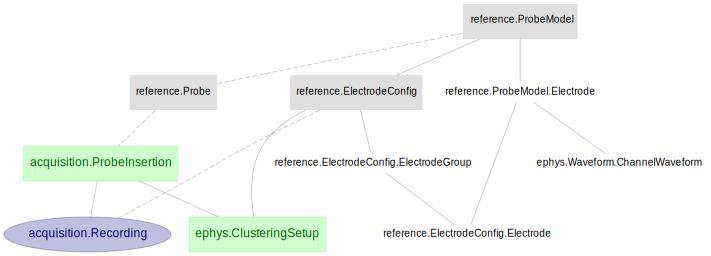

In [34]:
dj.ERD(reference.ProbeModel) + 2

In [33]:
reference.ProbeModel()

"probe_model nick name, or other user-friendly model name of this probe",probe_type
neuropixels_1.0,neuropixels
4-tetrode-array,tetrode_array
8-tetrode-array,tetrode_array


In [32]:
reference.Probe().describe()

# represent a physical probe
probe                : varchar(32)                  # unique identifier of this probe (e.g. serial number)
---
-> reference.ProbeModel



'# represent a physical probe\nprobe                : varchar(32)                  # unique identifier of this probe (e.g. serial number)\n---\n-> reference.ProbeModel\n'

In [30]:
acquisition.ProbeInsertion.describe()

-> mlims.Animal
insertion_time       : datetime                     # When this probe was inserted
---
-> reference.Probe
insertion_note=""    : varchar(1000)                # some notes



'-> mlims.Animal\ninsertion_time       : datetime                     # When this probe was inserted\n---\n-> reference.Probe\ninsertion_note=""    : varchar(1000)                # some notes\n'

In [14]:
acquisition.ProbeInsertion()

animal_id,datasource_id,insertion_time When this probe was inserted,probe unique identifier of this probe (e.g. serial number),insertion_note some notes
00342c6d86e97d43,0,2019-07-03 12:00:00,neuropixel_25558,
40bfa03a7a7018cc,0,2019-09-11 14:08:45,Neuropixel_1,Roger 1
40bfa03a7a7018cc,0,2019-09-11 14:09:22,Neuropixel_2,Roger 2
575882867c176190,0,2019-04-04 00:00:00,microdrive_86866,
61fd2ac184c13c73,0,2016-09-20 15:20:04,tetrode_74956,
61fd2ac184c13c73,0,2017-10-02 00:00:00,tetrode_74956,
6a61369265b193e8,0,2017-09-08 00:00:00,tetrode_74472,
6a61369265b193e8,0,2017-10-04 00:00:00,tetrode_74472,
724240a0a756020f,0,2018-03-15 12:00:00,microdrive_24321_1,
724240a0a756020f,0,2018-03-15 12:10:00,microdrive_24321_2,


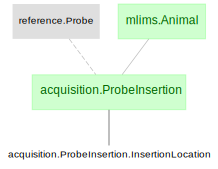

In [20]:
dj.ERD(acquisition.ProbeInsertion) - 1 + acquisition.ProbeInsertion.InsertionLocation

In [23]:
acquisition.ProbeInsertion.InsertionLocation()

animal_id,datasource_id,insertion_time When this probe was inserted,brain_area,hemisphere,skull_reference,ml_location (um) relative to the skull-reference,ap_location (um) relative to the skull-reference,dv_location (um) relative to the surface of the dura at the implant location,ml_angle (degree),ap_angle (degree)
00342c6d86e97d43,0,2019-07-03 12:00:00,MEC - Layer 2,right,lambda,4600.0,100.0,5000.0,0.0,30.0
40bfa03a7a7018cc,0,2019-09-11 14:08:45,MEC - Layer 2,left,lambda,4200.0,0.05,6000.0,25.0,0.0
40bfa03a7a7018cc,0,2019-09-11 14:09:22,MEC - Layer 2,right,lambda,4200.0,0.05,6000.0,25.0,0.0
575882867c176190,0,2019-04-04 00:00:00,MEC - Layer 2,right,lambda,0.0,100.0,1000.0,0.0,0.0
61fd2ac184c13c73,0,2016-09-20 15:20:04,unknown,right,bregma,nan,nan,nan,nan,nan
61fd2ac184c13c73,0,2017-10-02 00:00:00,unknown,left,bregma,nan,nan,nan,nan,nan
6a61369265b193e8,0,2017-09-08 00:00:00,unknown,left,bregma,nan,nan,nan,nan,nan
6a61369265b193e8,0,2017-10-04 00:00:00,unknown,left,bregma,nan,nan,nan,nan,nan
724240a0a756020f,0,2018-03-15 12:00:00,MEC - Layer 2,left,lambda,4600.0,100.0,1900.0,0.0,28.0
724240a0a756020f,0,2018-03-15 12:10:00,MEC - Layer 2,right,lambda,4600.0,100.0,1900.0,0.0,28.0


In each ***Session***, a ***Recording*** corresponds to a single continuous recording from a single probe, and thus is uniquely identifed by the following factors:

* The **session** that the recording belongs to
* A particular instance of an **inserted electrode probe** that the recording was performed on
* Exact start date and time of the recording

Given this, we expect a recording to **depend on** both a `Session` and a `ProbeInsertion`, but also contain an additional primary key attribute/column for the recording start time. We can indeed see this in the definition of the Recording table:

In [25]:
acquisition.Recording.describe();

-> acquisition.Session
-> acquisition.ProbeInsertion
recording_time       : datetime                     # start time of this recording
---
-> reference.RecordingSystem
-> reference.ElectrodeConfig
recording_order      : smallint                     # the ordering of this recording in this session
recording_duration   : float                        # (s) duration of this recording
recording_name=""    : varchar(40)                  # name of this recording (e.g. 27032019laserSess1)



Each ***Recording*** also contains additional information:
+ recording system (e.g. Axona, Neralynx, Neuropixels, Neurologger)
+ electrode configuration (e.g. subset of neuropixels sites, tetrode number)

and depending on the recording system, information needed to perform synchornization to a common time clock spanning the whole session can be found in the `acquisition.Recording.RecordingSync` part table.

![recording](../images/recording_detail_erd.png)

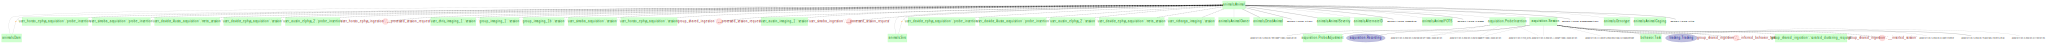

In [68]:
dj.ERD(acquisition.Session()) -1 + 1

In [69]:
acquisition.Session.Directories()

animal_id,datasource_id,session_time start time of this session,"repository e.g. 'Local', 'Network'","input_dir relative path (linux), without drive"
00342c6d86e97d43,0,2019-07-04 20:35:12,network,sampledata/neuropixel/Torgeir/25558/2019-07-04_20-33-01
40bfa03a7a7018cc,0,2019-09-17 19:43:06,network,neuropixel/shared_data/Roger/2019-09-17_19-41-14
61fd2ac184c13c73,0,2017-10-02 15:54:25,network,davidcr/74956/02102017
61fd2ac184c13c73,0,2018-01-02 11:20:23,network,davidcr/74956/02012018
6a61369265b193e8,0,2017-09-08 14:58:22,network,davidcr/74472/08092017
6a61369265b193e8,0,2017-10-04 11:15:32,network,davidcr/74472/04102017
6a61369265b193e8,0,2018-01-08 13:19:31,network,davidcr/74472/08012018
724240a0a756020f,0,2018-04-24 10:25:23,network,sampledata/deuteron/Torgeir/24321/20180424_01_light
96129eb1563c0b0d,0,2018-06-21 12:59:28,network,valentno/Data/Ratvissant/20180621/1
bbd19fe400fac5a6,0,2019-09-10 15:34:57,network,neuropixel/vnormand/Ratounette/2019-09-10_15-32-29


In [12]:
acquisition.Recording()

animal_id,datasource_id,session_time start time of this session,insertion_time When this probe was inserted,recording_time start time of this recording,recording_system,"probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),recording_order the ordering of this recording in this session,recording_duration (s) duration of this recording,recording_name name of this recording (e.g. 27032019laserSess1)
00342c6d86e97d43,0,2019-07-04 20:35:12,2019-07-03 12:00:00,2019-07-04 20:35:12,neuropixels,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,0,2405.48,npx_g0_t0.imec
40bfa03a7a7018cc,0,2019-09-17 19:43:06,2019-09-11 14:08:45,2019-09-17 19:43:06,neuropixels,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,0,7667.25,npx.imec
40bfa03a7a7018cc,0,2019-09-17 19:43:06,2019-09-11 14:09:22,2019-09-17 19:43:06,neuropixels,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,0,7667.45,npx.imec
61fd2ac184c13c73,0,2017-10-02 15:54:25,2017-10-02 00:00:00,2017-10-02 15:54:25,axona,4-tetrode-array,657119cc9e911c2c8a536abce16264f0,0,1958.0,02102017s1
61fd2ac184c13c73,0,2017-10-02 15:54:25,2017-10-02 00:00:00,2017-10-02 16:28:38,axona,4-tetrode-array,657119cc9e911c2c8a536abce16264f0,1,81.0,02102017laserSess1(1mw)
61fd2ac184c13c73,0,2017-10-02 15:54:25,2017-10-02 00:00:00,2017-10-02 16:30:46,axona,4-tetrode-array,657119cc9e911c2c8a536abce16264f0,2,81.0,02102017laserSess1(2mw)
61fd2ac184c13c73,0,2017-10-02 15:54:25,2017-10-02 00:00:00,2017-10-02 16:32:47,axona,4-tetrode-array,657119cc9e911c2c8a536abce16264f0,3,80.0,02102017laserSess1(3mw)
61fd2ac184c13c73,0,2017-10-02 15:54:25,2017-10-02 00:00:00,2017-10-02 16:34:32,axona,4-tetrode-array,657119cc9e911c2c8a536abce16264f0,4,81.0,02102017laserSess1(4mw)
61fd2ac184c13c73,0,2017-10-02 15:54:25,2017-10-02 00:00:00,2017-10-02 16:37:12,axona,4-tetrode-array,657119cc9e911c2c8a536abce16264f0,5,81.0,02102017laserSess1(7mw)
61fd2ac184c13c73,0,2017-10-02 15:54:25,2017-10-02 00:00:00,2017-10-02 16:38:46,axona,4-tetrode-array,657119cc9e911c2c8a536abce16264f0,6,80.0,02102017laserSess1(9mw)


# Organization of Clustering Data



For each ***Recording***, ***UnitSpikeTimes*** can be extracted, per ***Unit*** with spike times from this recording

Clusterings can be performed on:
+ Multiple concatenated sessions (although in most cases, just on one session)
+ Different time window(s) over the selected session(s)
+ Yielding units for this ***clustering***

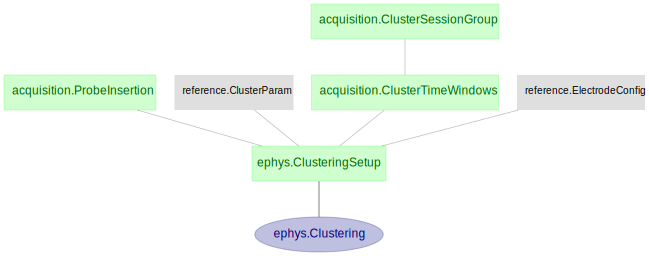

In [17]:
dj.ERD(ephys.ClusteringSetup) - 1 + ephys.Clustering + reference.ElectrodeConfig + acquisition.ClusterSessionGroup - reference.SyncMethod - reference.Repository + reference.ClusterParam

***ClusteringSetup*** is for users to specify:
+ the ***ClusterSessionGroup*** and ***ClusterTimeWindows***
+ the probe this clustering is performed on - ***ProbeInsertion***
+ the parameters to perform the clustering - ***ClusterParam***
+ the directory to output this clustering results 
+ the electrode configuration information

Note: all of this is taken care of in the ingestion routine (more on that later)

***Clustering*** - a processing step to either trigger the clustering or perform ingestion on performed clustering

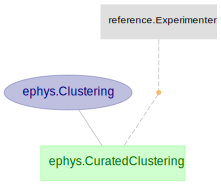

In [11]:
dj.ERD(ephys.CuratedClustering) + ephys.Clustering + reference.Experimenter

***CuratedClustering*** - insert a new curation:
+ the curator
+ the time of curation
+ the directory of the new curation results

# Unit & Spike times

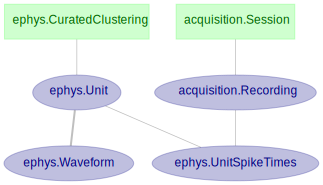

In [21]:
dj.ERD(ephys.Unit) + 1 + ephys.CuratedClustering + acquisition.Recording + acquisition.Session

In [25]:
ephys.UnitSpikeTimes()

animal_id,datasource_id,insertion_time When this probe was inserted,group_name,time_window_id or maybe a hash of all the part windows,cluster_method name of clustering method,"cluster_param_name some unique name, or maybe hash of the dict of the param (ordered)","probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),sync_method sync method name,curation_timestamps ensure complete datetime here to prevent collision (in the rare case of multiple people curate at the exact same datetime),unit,session_time start time of this session,recording_time start time of this recording,mean_firing_rate mean firing rate,spike_counts how many spikes in this recording of this unit,"unit_spike_times (s) spike times of this unit, relative to the start of the session this recording belongs to"
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,0,2019-09-17 19:43:06,2019-09-17 19:43:06,2.12436,16288,=BLOB=
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,1,2019-09-17 19:43:06,2019-09-17 19:43:06,4.88728,37472,=BLOB=
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,2,2019-09-17 19:43:06,2019-09-17 19:43:06,3.87792,29733,=BLOB=
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,3,2019-09-17 19:43:06,2019-09-17 19:43:06,1.21243,9296,=BLOB=
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,4,2019-09-17 19:43:06,2019-09-17 19:43:06,0.283544,2174,=BLOB=
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,5,2019-09-17 19:43:06,2019-09-17 19:43:06,0.618866,4745,=BLOB=
40bfa03a7a7018cc,0,2019-09-11 14:08:45,det_144c54937ff40b02a50281270644fc2d,a1c6a0bfe97cd18966cb6fdb87c75687,kilosort,default_kilosort,neuropixels_1.0,3bae3f7153f0305d02232efd41217754,linear_interp,2019-09-18 14:57:28,6,2019-09-17 19:43:06,2019-09-17 19:43:06,0.0164335,126,=BLOB=


#### Summary diagram of the clustering structure
![](../images/clustering_detail_erd.png)

# Tracking

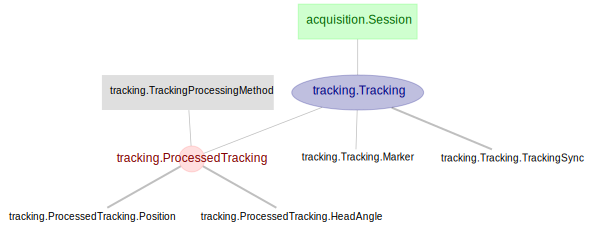

In [28]:
dj.ERD(tracking.Tracking) + 1 - tracking.MarkerSet + acquisition.Session + tracking.ProcessedTracking.Position + tracking.ProcessedTracking.HeadAngle + tracking.TrackingProcessingMethod

# Toward the results - Spikes and Tracking

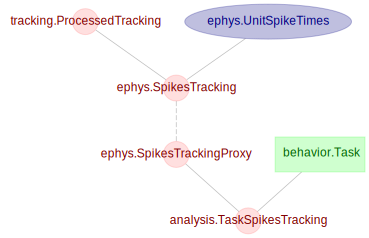

In [33]:
dj.ERD(ephys.SpikesTracking) - 1 + analysis.TaskSpikesTracking + behavior.Task

***UnitSpikeTimes*** and ***Tracking*** data can be matched together - resulting in the ***SpikesTracking***:
> The spike times and tracking data (e.g. position, speed, head angle, etc.) associated with each spike, per unit

And such ***SpikesTracking*** can then be further narrowed down to the task, in ***TaskSpikesTracking***

In [27]:
analysis.TaskSpikesTracking()

animal_id,datasource_id,session_time start time of this session,task_type,task_start (s) timestamp of task onset with respect to the start of the session,unit unit id,spike_tracking_hash hash of the SpikesTracking primary_key,cell_selection_params_name user-friendly name,spike_times (s) task-related spike times (time with respect to the start of the task),speed (cm/s) task-related speed at each spike times,x_pos (cm) task-related x-pos at each spike times,y_pos (cm) task-related y-pos at each spike times,z_pos (cm) task-related z-pos at each spike times,head_yaw (degree) task-related head yaw (left/right angle) at each spike times,head_pitch (degree) task-related head pitch (up/down) at each spike times,head_roll (degree) task-related head roll (clockwise/anticlockwise) at each spike times,angular_speed (degree/s) task-related head angular speed at each spike times
724240a0a756020f,0,2018-04-24 10:25:23,OpenField,0.00,0,2302a64000a8b5c6a347d228cede17b5,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
724240a0a756020f,0,2018-04-24 10:25:23,OpenField,0.00,1,8f26e58aa05acd610b65e908a907f038,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
724240a0a756020f,0,2018-04-24 10:25:23,OpenField,0.00,4,3b9eefe18801652fd5cf5901fb6a97f8,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
724240a0a756020f,0,2018-04-24 10:25:23,OpenField,0.00,6,209db0c7f1b4ba016ce05d703333d391,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
724240a0a756020f,0,2018-04-24 10:25:23,OpenField,0.00,12,6e812d06eb6de96d9517a94a9735f56f,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
724240a0a756020f,0,2018-04-24 10:25:23,OpenField,0.00,13,e29ae5f77cccb7d0acf5d5d020e110f1,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
724240a0a756020f,0,2018-04-24 10:25:23,OpenField,0.00,14,d42933ad6edea511b74abb397cfa8239,default,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


# Electrode Configuration

#### Electrode configuration represents the electrode grouping used in a particular recording from a probe:

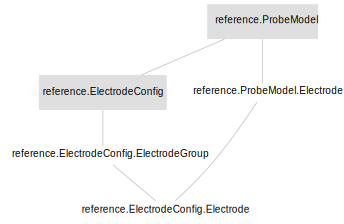

In [37]:
dj.ERD(reference.ElectrodeConfig.Electrode) - 1 + reference.ElectrodeConfig.ElectrodeGroup + reference.ProbeModel

For ***neuropixels*** probe: 
+ 1 group - which 384 channels used

For ***tetrode array*** probe:
+ each tetrode is a group
+ which channel assigned to which tetrode

In [43]:
reference.ElectrodeConfig()

"probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),electrode_config_name user friendly name
4-tetrode-array,222cc704a75a2aea7777cc0899d809fd,g_2345-4_chn
4-tetrode-array,657119cc9e911c2c8a536abce16264f0,g_5678-4_chn
4-tetrode-array,e1832bbcce7a2aa5fd12f97d7448f9be,g_6781-4_chn
4-tetrode-array,e9c6dac82a8bcb02825b0be07735a967,g_1234-4_chn
8-tetrode-array,00784804f372476162c7d90e94d8dc3d,g_12345678-4_chn
neuropixels_1.0,3bae3f7153f0305d02232efd41217754,g_0-384_chn


In [45]:
reference.ElectrodeConfig.ElectrodeGroup * reference.ElectrodeConfig & 'electrode_config_name = "g_5678-4_chn"'

"probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),electrode_group electrode group,electrode_config_name user friendly name
4-tetrode-array,657119cc9e911c2c8a536abce16264f0,5,g_5678-4_chn
4-tetrode-array,657119cc9e911c2c8a536abce16264f0,6,g_5678-4_chn
4-tetrode-array,657119cc9e911c2c8a536abce16264f0,7,g_5678-4_chn
4-tetrode-array,657119cc9e911c2c8a536abce16264f0,8,g_5678-4_chn


In [46]:
reference.ElectrodeConfig.Electrode * reference.ElectrodeConfig & 'electrode_config_name = "g_5678-4_chn"'

"probe_model nick name, or other user-friendly model name of this probe",electrode_config_id hash of the group and group_member (ensure uniqueness),electrode_group electrode group,electrode electrode,electrode_config_name user friendly name
4-tetrode-array,657119cc9e911c2c8a536abce16264f0,5,0,g_5678-4_chn
4-tetrode-array,657119cc9e911c2c8a536abce16264f0,5,1,g_5678-4_chn
4-tetrode-array,657119cc9e911c2c8a536abce16264f0,5,2,g_5678-4_chn
4-tetrode-array,657119cc9e911c2c8a536abce16264f0,5,3,g_5678-4_chn
4-tetrode-array,657119cc9e911c2c8a536abce16264f0,6,4,g_5678-4_chn
4-tetrode-array,657119cc9e911c2c8a536abce16264f0,6,5,g_5678-4_chn
4-tetrode-array,657119cc9e911c2c8a536abce16264f0,6,6,g_5678-4_chn
4-tetrode-array,657119cc9e911c2c8a536abce16264f0,6,7,g_5678-4_chn
4-tetrode-array,657119cc9e911c2c8a536abce16264f0,7,8,g_5678-4_chn
4-tetrode-array,657119cc9e911c2c8a536abce16264f0,7,9,g_5678-4_chn


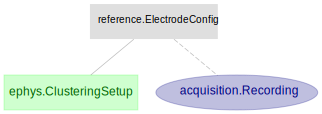

In [42]:
dj.ERD(reference.ElectrodeConfig) + ephys.ClusteringSetup + acquisition.Recording

# Probe Insertion Location 

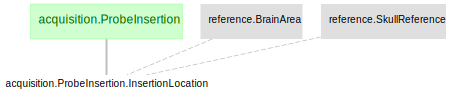

In [47]:
dj.ERD(acquisition.ProbeInsertion.InsertionLocation) - 1

In [48]:
acquisition.ProbeInsertion.InsertionLocation.describe();

-> acquisition.ProbeInsertion
---
-> reference.BrainArea
hemisphere           : enum('left','right')         
-> reference.SkullReference
ml_location=null     : float                        # (um) relative to the skull-reference
ap_location=null     : float                        # (um) relative to the skull-reference
dv_location=null     : float                        # (um) relative to the surface of the dura at the implant location
ml_angle=null        : float                        # (degree)
ap_angle=null        : float                        # (degree)



# Probe Adjustment

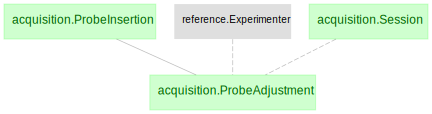

In [49]:
dj.ERD(acquisition.ProbeAdjustment) - 1

In [50]:
acquisition.ProbeAdjustment.describe();

-> acquisition.ProbeInsertion
adjustment_time      : datetime                     
---
-> [nullable] acquisition.Session
-> reference.Experimenter
estimated_depth_change=null : float                        # (um) positive: moving more dorsal (shallower), negative: moving more ventral (deeper)
adjustment           : varchar(128)                 # new depth (ideally)

